# Week 2 Mini project
## Predicting copper future price 

### 1. Background

A copper future is a legally binding agreement to buy or sell a standard quantity of Grade-A cathode copper at a preset price for delivery (or cash‐settlement) on a future date. Producers hedge price risk, manufacturers lock-in costs, and speculators trade anticipated moves.

There are three major future exchanges that trade copper contracts, namely, Shanghai Futures Exchange (CU), London metal exchange (CA), and CME Group / COMEX Copper (HG). Copper contracts in the three exchanges often share similar prices but are almost never identical. This is because the three markets operate in different time, and are technically selling copper contrasts in different countries. A brief summary of the differences across the three exchanges can be found at the end of this document. 

In this project, we will try to leverage the three exchange markets as well as the abudant data on the Internet to build a predictive model for U.S. copper contract prices. 

> In a recent announcement, a $50\%$ tariff will be imposed on imported copper to U.S., which should drive up the U.S. copper contract price. However, according to [a news piece](https://www.reuters.com/markets/commodities/trumps-copper-tariffs-wont-lift-us-output-will-boost-costs-2025-07-10/) by Reuters: "U.S. copper contracts rose to a 26% premium over their London equivalent on Wednesday from a 13% premium before Trump's announcement. That 26% premium is still well short of the 50% tariff, likely indicating the uncertainty in the market as to what types of copper products will be subject to tariffs or the risk of a lower rate for some countries." 

### 2. Objective

The grand objective is simple: to build a model to predict the U.S. copper contracts price per day. You are free to fit any models or use any data you can find, as long as the model uses only data before the market opens on the day of interest (i.e., no data leakage). 

To get started, you can run the following cells to download the copper contract prices from the three exchanges. You might need to install some libraries if you see errors complaining on libraries found. 


In [70]:
%pip install yfinance
import yfinance as yf
import pandas as pd

# ------------------------------------------------------------
# 1.  Download daily front-month copper futures (COMEX)
# ------------------------------------------------------------
ticker = "HG=F"                # Copper continuous contract on Yahoo Finance
start  = "2010-01-01"          # any start date you like
end    = "2025-07-15"          # or leave end=None for “today”

NY = yf.download(ticker, start=start, end=end, interval="1d")

# Quick sanity-check
NY.head()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/var/folders/x8/r3trhgk10jz0y69mhxk1mpd00000gn/T/ipykernel_69148/1926688803.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  NY = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed



Price,Close,High,Low,Open,Volume
Ticker,HG=F,HG=F,HG=F,HG=F,HG=F
Date,,,,,
2010-01-04,3.3880,3.4090,3.3530,3.3880,404
2010-01-05,3.3960,3.4110,3.3685,3.3960,242
2010-01-06,3.4775,3.4995,3.4335,3.4775,109
2010-01-07,3.4115,3.5235,3.4110,3.4995,326
2010-01-08,3.3880,3.4220,3.3800,3.3880,311


In [71]:
NY.tail()
NY['High'].info()
NY

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3905 entries, 2010-01-04 to 2025-07-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HG=F    3905 non-null   float64
dtypes: float64(1)
memory usage: 61.0 KB


Price,Close,High,Low,Open,Volume
Ticker,HG=F,HG=F,HG=F,HG=F,HG=F
Date,,,,,
2010-01-04,3.3880,3.4090,3.3530,3.3880,404
2010-01-05,3.3960,3.4110,3.3685,3.3960,242
2010-01-06,3.4775,3.4995,3.4335,3.4775,109
2010-01-07,3.4115,3.5235,3.4110,3.4995,326
2010-01-08,3.3880,3.4220,3.3800,3.3880,311
...,...,...,...,...,...
2025-07-08,5.6450,5.6450,4.9495,4.9680,922
2025-07-09,5.4435,5.6820,5.3975,5.4670,857


In [72]:
%pip install akshare
%pip install pandas_datareader

import akshare as ak
import datetime as dt
from pandas_datareader import data as web

MT_TO_LB = 2204.62262    
# main (dominant) copper contract from Sina Finance, date index ascending
SHFE = ak.futures_main_sina(symbol="CU0",end_date="20250715",start_date="20150101")   # "CU0" -> SHFE copper continuous
# rename to English
SHFE = SHFE.rename(columns={
    "日期": "date",
    "开盘价": "open",
    "最高价": "high",
    "最低价": "low",
    "收盘价": "close",
    "成交量": "volume",
    "持仓量": "open_interest",
    "动态结算价": "settlement_price"
})
# ---- FX: CNY per USD (daily) --------------------------------
fx = (
    web.DataReader(
        "DEXCHUS",      # Yuan per 1 USD (FRED)
        "fred",
        2005,
        2025  # or leave end=None for “today”
    )
    .rename(columns={"DEXCHUS": "cny_per_usd"})
    .ffill()                        # forward-fill weekends / holidays
)

# ---- merge & convert ----------------------------------------
SHFE.set_index("date", inplace=True)        # make 'date' the index
SHFE.sort_index(inplace=True)               # (optional) keep rows in chrono order

SHFE = SHFE.join(fx, how="left")
SHFE["usd_per_ton"] = SHFE["close"] / SHFE["cny_per_usd"]
SHFE["usd_per_lb"]  = SHFE["usd_per_ton"] / MT_TO_LB

SHFE.head()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


,open,high,low,close,volume,open_interest,settlement_price,cny_per_usd,usd_per_ton,usd_per_lb
date,,,,,,,,,,
2015-01-05,45500,45570,44990,45080,189194,325160,45250,6.2201,7247.471906,3.287398
2015-01-06,44210,44910,43980,44800,447986,310542,44570,6.2125,7211.267606,3.270976
2015-01-07,44640,44840,44420,44650,317816,301058,44660,6.2127,7186.891368,3.259919
2015-01-08,44650,44890,44580,44680,208524,297932,44740,6.2143,7189.868529,3.261270
2015-01-09,45000,45050,44250,44250,384066,308602,44550,6.2085,7127.325441,3.232900


In [73]:
SHFE.tail()

,open,high,low,close,volume,open_interest,settlement_price,cny_per_usd,usd_per_ton,usd_per_lb
date,,,,,,,,,,
2025-07-09,79590,80170,78270,78400,162594,193999,78910,NaN,NaN,NaN
2025-07-10,78340,78680,78160,78600,99231,181068,78390,NaN,NaN,NaN
2025-07-11,78700,78810,78370,78430,81666,178678,78530,NaN,NaN,NaN
2025-07-14,78040,78520,78010,78400,79133,172200,78290,NaN,NaN,NaN
2025-07-15,77900,78160,77700,78090,81646,169903,77930,NaN,NaN,NaN


In [74]:
# The LME copper price is available MONTHLY from the IMF database
start = dt.datetime(1990, 1, 1)
LME= web.DataReader("PCOPPUSDM", "fred", start)   # IMF / LME cash price

LME.rename(columns={"PCOPPUSDM": "usd_per_ton"}, inplace=True)
LME["usd_per_lb"] = LME["usd_per_ton"] / MT_TO_LB

LME.head()  

,usd_per_ton,usd_per_lb
DATE,,
1990-01-01,2365.556991,1.072999
1990-02-01,2358.943400,1.069999
1990-03-01,2625.702723,1.190999
1990-04-01,2685.226891,1.217998
1990-05-01,2740.342391,1.242998


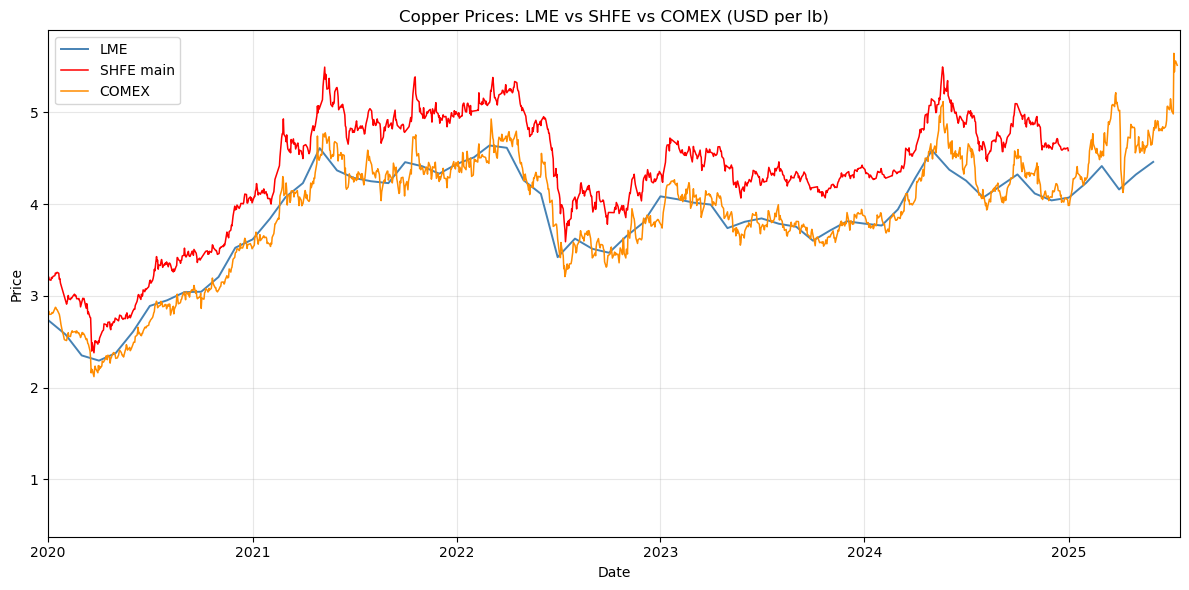

In [75]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(LME.index, LME["usd_per_lb"],
         label="LME", linewidth=1.4, color="steelblue")

plt.plot(SHFE.index, SHFE["usd_per_lb"],
         label="SHFE main", linewidth=1.1, color="red")
plt.plot(NY.index, NY["Close"],
         label="COMEX", linewidth=1.1, color="darkorange")

plt.title("Copper Prices: LME vs SHFE vs COMEX (USD per lb)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
start_xlim = pd.Timestamp("2020-01-01")
end_xlim   = pd.Timestamp("2025-07-19")
plt.xlim(start_xlim, end_xlim)  
plt.show()

## Appendix: Summary of the three exchanges

| Exchange (venue code)                       | Contract unit        | Price quote   | Typical trading hours (local)         | Warehouse/delivery system                                   | Tick size                                                      |
| ------------------------------------------- | -------------------- | ------------- | ------------------------------------- | ----------------------------------------------------------- | -------------------------------------------------------------- |
| **London Metal Exchange – LME Copper (CA)** | 25 metric tonnes     | USD per tonne | 01:00-19:00 London (ring + LMEselect) | Global LME-approved sheds; *“warrants”* transferable        | USD 0.10/tonne ([Lme][1])                                      |
| **Shanghai Futures Exchange – SHFE 铜 (CU)** | 5 t                  | CNY per ton   | 09:00-15:00 & 21:00-02:00 Beijing     | Mainland China warehouses; VAT & import‐quota rules apply   | ¥10/ton (≈USD 1.4) ([tsite.shfe.com.cn][2], [Barchart.com][3]) |
| **CME Group / COMEX Copper (HG)**           | 25 000 lb (≈11.34 t) | USD ¢ per lb  | 18:00-17:00 ET (electronically)       | U.S. COMEX-licensed warehouses; deliverable Grade 1 cathode | USD 0.0005/lb ([CME Group][4], [CME Group][5])                 |

[1]: https://www.lme.com/en/metals/non-ferrous/lme-copper/contract-specifications?utm_source=chatgpt.com "Contract specifications | London Metal Exchange"
[2]: https://tsite.shfe.com.cn/eng/market/futures/metal/cu/index.html?utm_source=chatgpt.com "Copper"
[3]: https://www.barchart.com/futures/quotes/VC%2A0/profile?utm_source=chatgpt.com "SHFE Copper Aug '25 Futures Contract Specifications - Barchart.com"
[4]: https://www.cmegroup.com/markets/metals/base/copper.contractSpecs.html?utm_source=chatgpt.com "Copper Futures Contract Specs - CME Group"
[5]: https://www.cmegroup.com/markets/metals/base/copper.html?utm_source=chatgpt.com "Copper Futures Overview - CME Group"


In [76]:
# Assuming NY, SHFE, LME are your loaded DataFrames
df = pd.DataFrame()
df['HG_Close'] = NY['Close']
df['CU_usd_per_lb'] = SHFE['usd_per_lb']
df['CA_usd_per_lb'] = LME['usd_per_lb']
df.dropna(inplace=True)



In [77]:
# Enhanced feature engineering using all three copper futures
print("Creating comprehensive features from all three copper exchanges...")

# 1. Current prices from all exchanges
df['COMEX_current'] = df['HG_Close']
df['SHFE_current'] = df['CU_usd_per_lb'] 
df['LME_current'] = df['CA_usd_per_lb']

# 2. Lagged features (past 1-5 days) for all exchanges
n_days = 5
for exchange, col in [('COMEX', 'HG_Close'), ('SHFE', 'CU_usd_per_lb'), ('LME', 'CA_usd_per_lb')]:
    for i in range(1, n_days + 1):
        df[f'{exchange}_lag_{i}'] = df[col].shift(i)

# 3. Price spreads and ratios between exchanges
df['COMEX_SHFE_spread'] = df['HG_Close'] - df['CU_usd_per_lb']
df['COMEX_LME_spread'] = df['HG_Close'] - df['CA_usd_per_lb']
df['SHFE_LME_spread'] = df['CU_usd_per_lb'] - df['CA_usd_per_lb']

df['COMEX_SHFE_ratio'] = df['HG_Close'] / df['CU_usd_per_lb']
df['COMEX_LME_ratio'] = df['HG_Close'] / df['CA_usd_per_lb']
df['SHFE_LME_ratio'] = df['CU_usd_per_lb'] / df['CA_usd_per_lb']

# 4. Moving averages (3, 7, and 14 days) for all exchanges
for exchange, col in [('COMEX', 'HG_Close'), ('SHFE', 'CU_usd_per_lb'), ('LME', 'CA_usd_per_lb')]:
    for window in [3, 7, 14]:
        df[f'{exchange}_MA_{window}'] = df[col].rolling(window=window).mean()
        # Price relative to moving average
        df[f'{exchange}_vs_MA_{window}'] = df[col] / df[f'{exchange}_MA_{window}'] - 1

# 5. Volatility features (rolling standard deviation)
for exchange, col in [('COMEX', 'HG_Close'), ('SHFE', 'CU_usd_per_lb'), ('LME', 'CA_usd_per_lb')]:
    for window in [7, 14]:
        df[f'{exchange}_volatility_{window}'] = df[col].rolling(window=window).std()

# 6. Price changes and momentum
for exchange, col in [('COMEX', 'HG_Close'), ('SHFE', 'CU_usd_per_lb'), ('LME', 'CA_usd_per_lb')]:
    df[f'{exchange}_change_1d'] = df[col].pct_change(1)
    df[f'{exchange}_change_3d'] = df[col].pct_change(3)
    df[f'{exchange}_change_7d'] = df[col].pct_change(7)

# 7. Cross-exchange momentum indicators
df['momentum_spread'] = (df['COMEX_change_1d'] - df['SHFE_change_1d'])
df['avg_exchange_momentum'] = (df['COMEX_change_1d'] + df['SHFE_change_1d'] + df['LME_change_1d']) / 3

# Drop rows with missing values
print(f"Dataset shape before cleaning: {df.shape}")
df.dropna(inplace=True)
print(f"Dataset shape after cleaning: {df.shape}")

# Define features and target
# Exclude the target variable and current prices that would cause data leakage
exclude_cols = ['HG_Close', 'COMEX_current']
X = df.drop(columns=exclude_cols)
y = df['HG_Close']

print(f"\nFeature set includes {X.shape[1]} features:")
feature_categories = {
    'Current Prices': [col for col in X.columns if 'current' in col],
    'Lagged Prices': [col for col in X.columns if 'lag' in col],
    'Price Spreads': [col for col in X.columns if 'spread' in col],
    'Price Ratios': [col for col in X.columns if 'ratio' in col],
    'Moving Averages': [col for col in X.columns if 'MA' in col and 'vs_MA' not in col],
    'MA Deviations': [col for col in X.columns if 'vs_MA' in col],
    'Volatility': [col for col in X.columns if 'volatility' in col],
    'Price Changes': [col for col in X.columns if 'change' in col],
    'Momentum': [col for col in X.columns if 'momentum' in col]
}

for category, features in feature_categories.items():
    if features:
        print(f"  {category}: {len(features)} features")


Creating comprehensive features from all three copper exchanges...
Dataset shape before cleaning: (66, 62)
Dataset shape after cleaning: (53, 62)

Feature set includes 60 features:
  Current Prices: 2 features
  Lagged Prices: 15 features
  Price Spreads: 4 features
  Price Ratios: 3 features
  Moving Averages: 9 features
  MA Deviations: 9 features
  Volatility: 6 features
  Price Changes: 10 features
  Momentum: 2 features


In [78]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


Dataset Information:
Total samples: 53
Training samples: 42 (79.2%)
Validation samples: 11 (20.8%)
Training period: 2016-11-01 to 2023-03-01
Validation period: 2023-06-01 to 2024-11-01



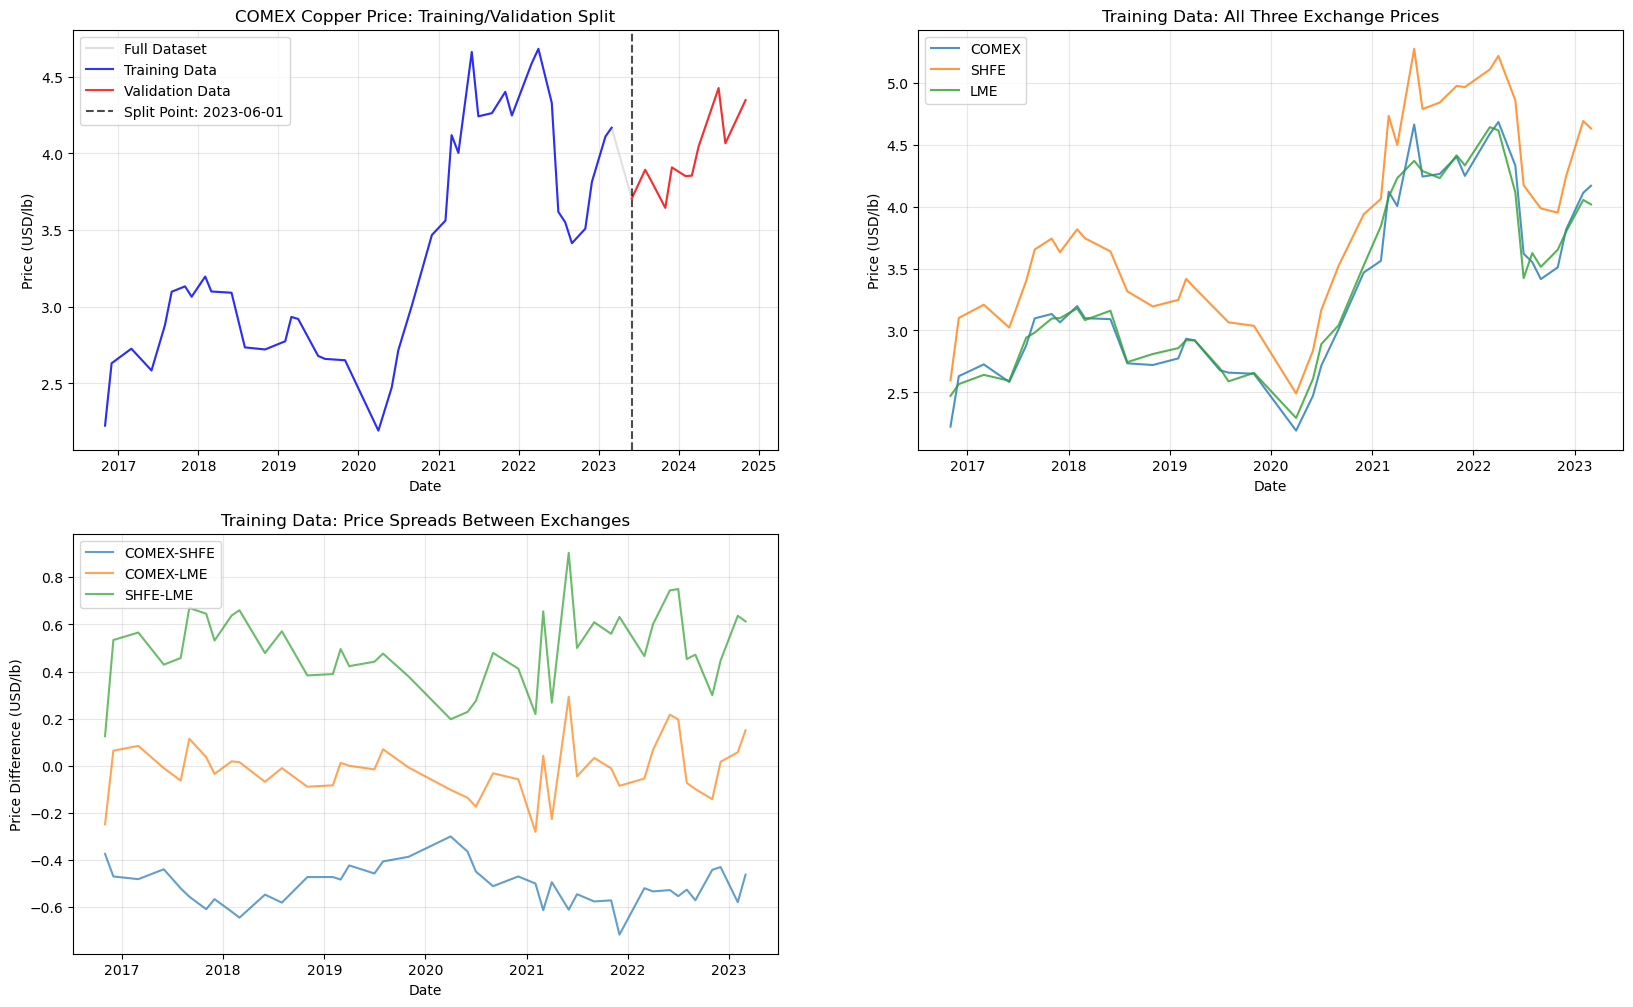

In [79]:
# Visualize the training/validation split and comprehensive feature analysis
import matplotlib.pyplot as plt
import seaborn as sns

print("Dataset Information:")
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Training period: {y_train.index[0].strftime('%Y-%m-%d')} to {y_train.index[-1].strftime('%Y-%m-%d')}")
print(f"Validation period: {y_val.index[0].strftime('%Y-%m-%d')} to {y_val.index[-1].strftime('%Y-%m-%d')}")
print()

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# Plot 1: Full time series with train/validation split highlighted
ax1 = plt.subplot(2, 2, 1)
ax1.plot(df.index, df['HG_Close'], color='lightgray', alpha=0.7, label='Full Dataset')
ax1.plot(y_train.index, y_train, color='blue', alpha=0.8, label='Training Data', linewidth=1.5)
ax1.plot(y_val.index, y_val, color='red', alpha=0.8, label='Validation Data', linewidth=1.5)

# Add vertical line to show split point
split_date = y_val.index[0]
ax1.axvline(x=split_date, color='black', linestyle='--', alpha=0.7, label=f'Split Point: {split_date.strftime("%Y-%m-%d")}')

ax1.set_title('COMEX Copper Price: Training/Validation Split')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD/lb)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Current prices from all three exchanges
ax2 = plt.subplot(2, 2, 2)
ax2.plot(y_train.index, df.loc[y_train.index, 'COMEX_current'], label='COMEX', alpha=0.8)
ax2.plot(y_train.index, df.loc[y_train.index, 'SHFE_current'], label='SHFE', alpha=0.8)
ax2.plot(y_train.index, df.loc[y_train.index, 'LME_current'], label='LME', alpha=0.8)
ax2.set_title('Training Data: All Three Exchange Prices')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price (USD/lb)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Price spreads between exchanges
ax3 = plt.subplot(2, 2, 3)
ax3.plot(y_train.index, df.loc[y_train.index, 'COMEX_SHFE_spread'], label='COMEX-SHFE', alpha=0.7)
ax3.plot(y_train.index, df.loc[y_train.index, 'COMEX_LME_spread'], label='COMEX-LME', alpha=0.7)
ax3.plot(y_train.index, df.loc[y_train.index, 'SHFE_LME_spread'], label='SHFE-LME', alpha=0.7)
ax3.set_title('Training Data: Price Spreads Between Exchanges')
ax3.set_xlabel('Date')
ax3.set_ylabel('Price Difference (USD/lb)')
ax3.legend()
ax3.grid(True, alpha=0.3)




In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print("MSE:", mean_squared_error(y_val, y_pred))
print("R2:", r2_score(y_val, y_pred))


MSE: 0.011614093966931381
R2: 0.787558068388789


In [81]:
# Predict future COMEX prices when SHFE data is missing (e.g., after Nov 2024)
import numpy as np

# 1. Select future dates where SHFE is missing but LME and COMEX are available
df_future = df[df['SHFE_current'].isna() & df['LME_current'].notna() & df['COMEX_current'].notna()].copy()

if len(df_future) == 0:
    print("No future dates found with missing SHFE but available LME/COMEX. Adjust the filter as needed.")
else:
    # 2. Impute missing SHFE features (forward-fill with last available value)
    last_shfe = df['SHFE_current'].ffill().iloc[-1]
    shfe_cols = [col for col in X.columns if 'SHFE' in col]
    for col in shfe_cols:
        if col in df_future.columns:
            df_future[col] = df_future[col].fillna(df[col].ffill()[col].iloc[-1])

    # 3. Prepare the feature matrix for prediction (ensure same columns/order as X_train)
    X_future = df_future[X_train.columns]

    # 4. Predict future COMEX prices
    future_preds = model.predict(X_future)
    df_future['Predicted_COMEX'] = future_preds
    print("Predicted COMEX prices for future dates (with imputed SHFE features):")
    display(df_future[['Predicted_COMEX']].head())

No future dates found with missing SHFE but available LME/COMEX. Adjust the filter as needed.


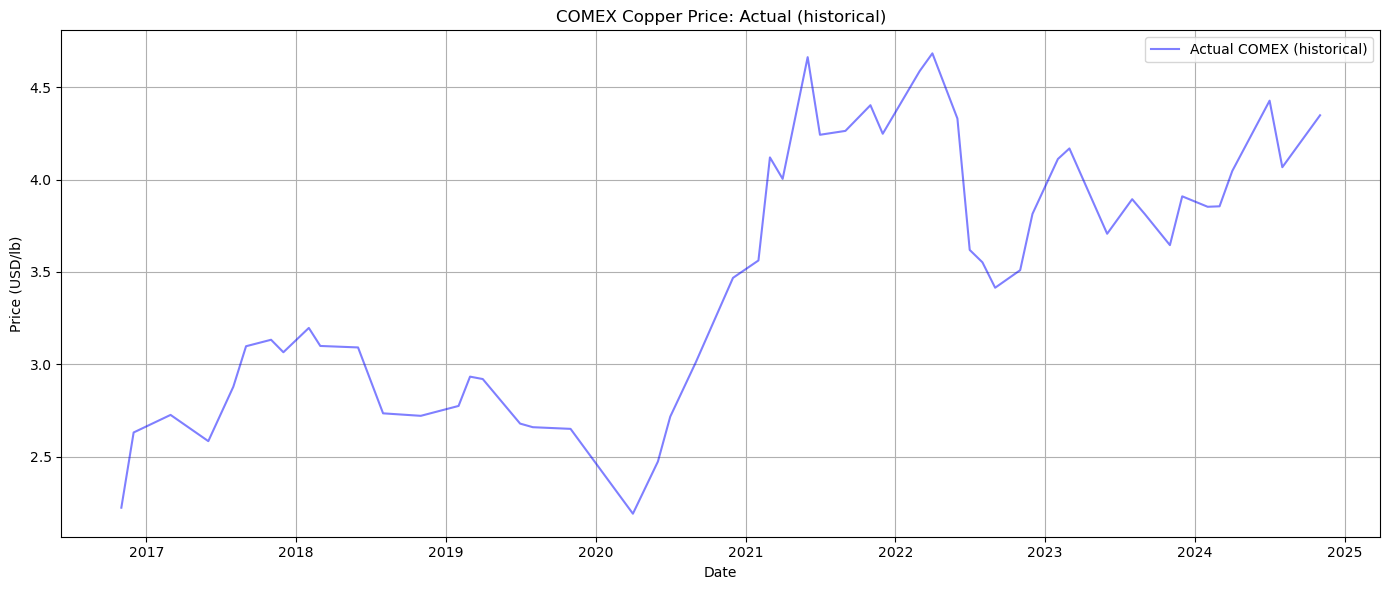

In [82]:
# Plot predicted COMEX prices for 2025 alongside historical actual prices
import matplotlib.pyplot as plt

# Filter for 2025 predictions (or adjust as needed)
pred_2025 = df_future[df_future.index.year == 2025] if 'df_future' in locals() else None

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['HG_Close'], label='Actual COMEX (historical)', color='blue', alpha=0.5)
if pred_2025 is not None and not pred_2025.empty:
    plt.plot(pred_2025.index, pred_2025['Predicted_COMEX'], label='Predicted COMEX (2025)', color='orange', marker='o')
    plt.title('COMEX Copper Price: Actual (historical) and Predicted (2025)')
else:
    plt.title('COMEX Copper Price: Actual (historical)')
plt.xlabel('Date')
plt.ylabel('Price (USD/lb)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

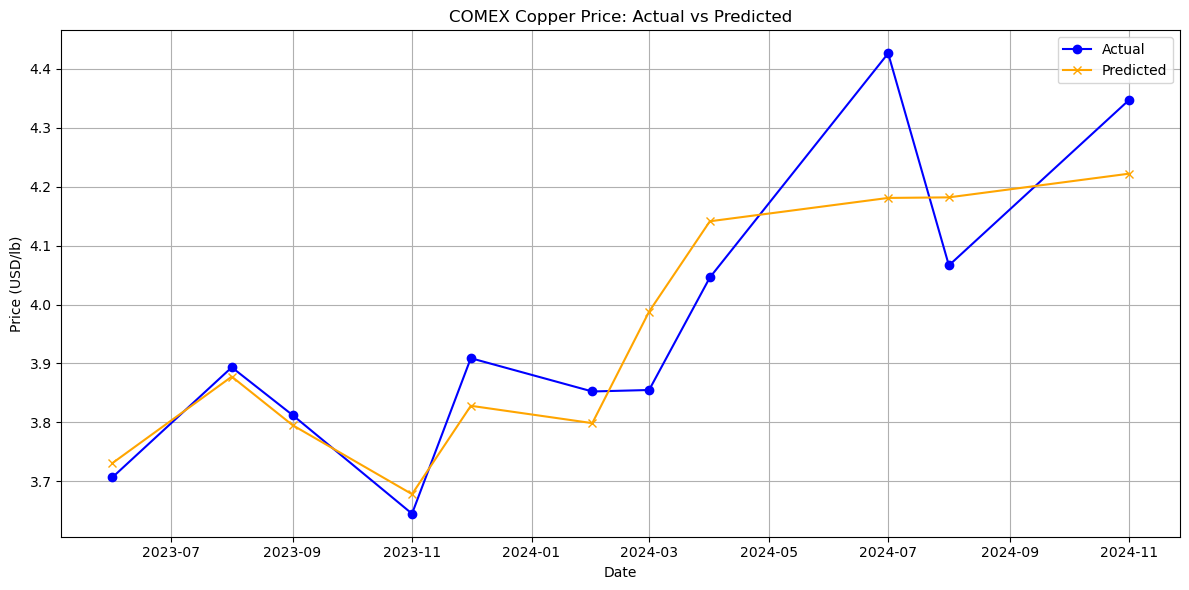

interactive(children=(IntSlider(value=0, description='Index', max=10), Output()), _dom_classes=('widget-intera…

In [83]:

import ipywidgets as widgets
from ipywidgets import interact

import matplotlib.pyplot as plt

# Prepare DataFrame for plotting
results_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred
}, index=y_val.index)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], marker='o', label='Actual', color='blue')
plt.plot(results_df.index, results_df['Predicted'], marker='x', label='Predicted', color='orange')
plt.title('COMEX Copper Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price (USD/lb)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Interactive widget to inspect predictions
def show_prediction(idx):
    date = results_df.index[idx]
    actual = results_df.iloc[idx]['Actual']
    predicted = results_df.iloc[idx]['Predicted']
    print(f"Date: {date.strftime('%Y-%m-%d')}")
    print(f"Actual:    {actual:.4f}")
    print(f"Predicted: {predicted:.4f}")

interact(show_prediction, idx=widgets.IntSlider(min=0, max=len(results_df)-1, step=1, value=0, description='Index'));